This notebook splits the Allen C01 datasets into glutamatergic and GABAergic subsets.

In [2]:
import loompy as lp
import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import time
import os.path


In [14]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


Using device:  cpu


In [16]:
dataset_meta = ['C01']
# 
# subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
# subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic','GABAergic']
dataset_names =  ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [17]:

import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


In [18]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
omitted_subtypes = ()


In [19]:
raw_data_locations

['C01', 'C01']

Dataset C01. 
	12363 barcodes in loom, 11116 pass filter. 10173 in annotations; of these, 10138 in loom and 9066 in filtered loom.
	Glutamatergic: 6702 cells in annotations. 6699 in loom. 6629 pass filter.
	GABAergic: 750 cells in annotations. 750 in loom. 728 pass filter.


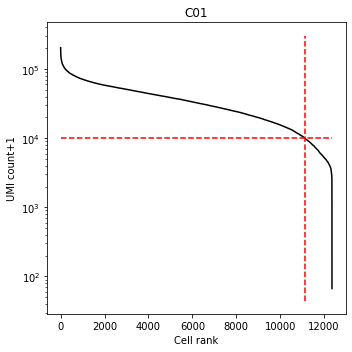

In [20]:
cf = []
thr_lb = [1e4]*4

fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[0]
    dataset_name = raw_data_locations[0]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for cluster in cluster_names:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
    ax1.set_title(dataset_name)
# fig_dir = './figs/'
# fig_string = fig_dir + 'kneeplots_allen_B08.png'
fig1.tight_layout()
# plt.savefig(fig_string,dpi=450)


In [23]:
outdir = '/home/ggorin/projects/monod_examples/sample_data/'

In [30]:
S[:,cf[0]].shape

(32285, 6629)

In [33]:
celltype_abbr = ['glu','gaba']
for i in range(len(cluster_names)):
    S_ = S[:,cf[i]]
    U_ = U[:,cf[i]]
    bc_filt = bcs[cf[i]]
    lp.create(outdir+'allen_{}_{}.loom'.format(dataset_meta[0],celltype_abbr[i]),\
          layers={'':scipy.sparse.csr_matrix(S_.shape),
                  spliced_layer:S_,
                  unspliced_layer:U_},\
                  row_attrs={gene_attr:gene_names},\
                  col_attrs={cell_attr:bc_filt})
    print(S_.shape)

(32285, 6629)
(32285, 728)


In [34]:
!tar cvzf - /home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom | split --bytes=50MB - /home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.tar.gz.


tar: Removing leading `/' from member names
/home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom


In [35]:
!tar cvzf - /home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.loom | split --bytes=50MB - /home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.tar.gz.


tar: Removing leading `/' from member names
/home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.loom
